# 05. 계층적 군집 분석 - Hierarchical Clustering

## 목적
커뮤니티 간 언어적 친족도를 덴드로그램으로 표현합니다.

## 계층적 군집이란?
- 데이터를 계층적 트리 구조로 그룹화
- 방언학에서 전통적으로 많이 사용
- 덴드로그램으로 친족 관계 시각화

In [1]:
import pandas as pd
import numpy as np
import json
from collections import Counter
from pathlib import Path
from scipy.spatial.distance import pdist, squareform
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
import matplotlib.pyplot as plt

plt.rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False

results_dir = Path('../data/results')
results_dir.mkdir(parents=True, exist_ok=True)

In [2]:
# 프로젝트 루트를 Python 경로에 추가
import sys
from pathlib import Path
project_root = Path('..').resolve()
sys.path.insert(0, str(project_root))

from scripts.analysis.analyze import load_and_balance_data

# 데이터 로드 및 밸런싱
expanded_dir = Path('../data/processed/expanded')
df = load_and_balance_data(expanded_dir)

# 데이터 로드
print(f"Total posts: {len(df)}")


발견된 파일: 8개
  - expanded_dcinside_향수화장품_갤러리.csv: 17381행
  - expanded_dcinside_수능_갤러리.csv: 9327행
  - expanded_dcinside_해외축구_갤러리.csv: 5700행
  - expanded_dcinside_국내연예-남자여자연예인_갤러리.csv: 14430행
  - expanded_dcinside_남자연예인_갤러리.csv: 6844행
  - expanded_theqoo_beauty_category_25604.csv: 17199행
  - expanded_dcinside_리그오브레전드_갤러리.csv: 9075행
  - expanded_theqoo_ktalk_category_1947874.csv: 11361행

⚖️ 밸런싱 기준: 최소 5700행 (랜덤 샘플링)
✅ 병합 완료: 총 45600행 (커뮤니티당 5700행)
데이터 파싱 중 (종결 어미, 기호)...
Total posts: 45600


## 1. 특성 벡터 생성

In [4]:
communities = df['community'].unique()

# 어미는 이미 데이터 전처리 단계에서 정규화됨
all_endings_flat = [item[0] for sublist in df['all_endings'] for item in sublist]
top_endings = [e[0] for e in Counter(all_endings_flat).most_common(30)]
all_symbols_flat = [item for sublist in df['symbols'] for item in sublist]
top_symbols = [e[0] for e in Counter(all_symbols_flat).most_common(10)]

feature_vectors = []
community_labels = []

for comm in communities:
    comm_df = df[df['community'] == comm]
    total_posts = len(comm_df)
    
    comm_endings = [item[0] for sublist in comm_df['all_endings'] for item in sublist]
    ending_counts = Counter(comm_endings)
    ending_features = [ending_counts.get(e, 0) / total_posts for e in top_endings]
    
    
    comm_symbols = [item for sublist in comm_df['symbols'] for item in sublist]
    symbol_counts = Counter(comm_symbols)
    symbol_features = [symbol_counts.get(s, 0) / total_posts for s in top_symbols]
    
    feature_vector = ending_features + symbol_features
    feature_vectors.append(feature_vector)
    # 라벨 간소화
    short_name = comm.replace('dcinside_', 'DC:').replace('theqoo_', 'TQ:')
    short_name = short_name.replace('_갤러리', '').replace('/category/', ':')
    community_labels.append(short_name)

feature_matrix = np.array(feature_vectors)
print(f"Feature matrix: {feature_matrix.shape}")

Feature matrix: (8, 40)


## 2. 계층적 군집 수행

In [5]:
# Ward linkage 방법
linkage_matrix = linkage(feature_matrix, method='ward')

print("Linkage matrix shape:", linkage_matrix.shape)

Linkage matrix shape: (7, 4)


## 3. 덴드로그램 시각화

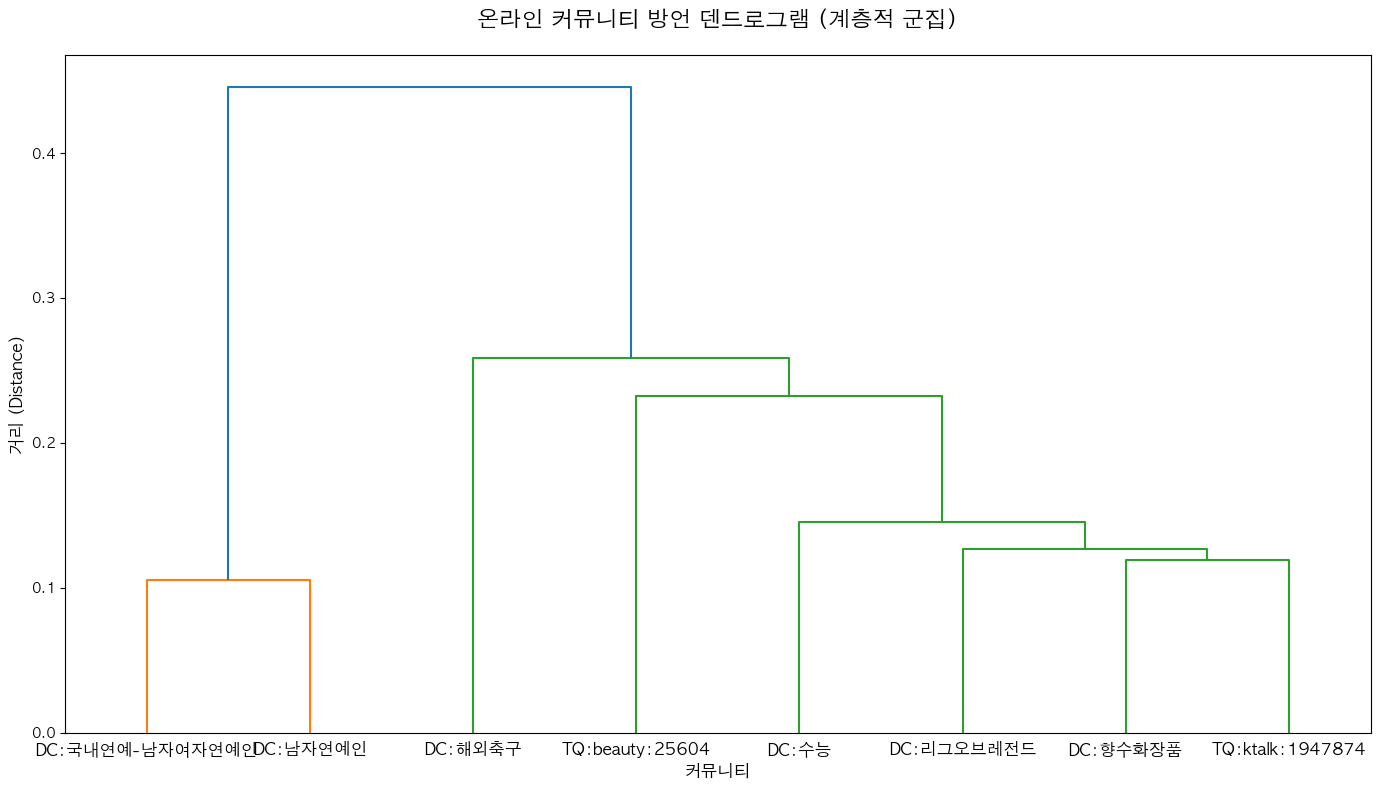

저장: ../data/results/dendrogram.png


In [6]:
plt.figure(figsize=(14, 8))
dendrogram(linkage_matrix, labels=community_labels, leaf_font_size=12)
plt.title('온라인 커뮤니티 방언 덴드로그램 (계층적 군집)', fontsize=16, pad=20)
plt.xlabel('커뮤니티', fontsize=12)
plt.ylabel('거리 (Distance)', fontsize=12)
plt.tight_layout()
plt.savefig(results_dir / 'dendrogram.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"저장: {results_dir / 'dendrogram.png'}")

## 4. k개 군집으로 분할 (k=3)

In [7]:
# 3개 군집으로 분할
k = 3
cluster_labels = fcluster(linkage_matrix, k, criterion='maxclust')

print(f"{k}개 군집 결과:")
for i, comm in enumerate(community_labels):
    print(f"  {comm}: 군집 {cluster_labels[i]}")

3개 군집 결과:
  DC:향수화장품: 군집 2
  DC:수능: 군집 2
  DC:해외축구: 군집 3
  DC:국내연예-남자여자연예인: 군집 1
  DC:남자연예인: 군집 1
  TQ:beauty:25604: 군집 2
  DC:리그오브레전드: 군집 2
  TQ:ktalk:1947874: 군집 2


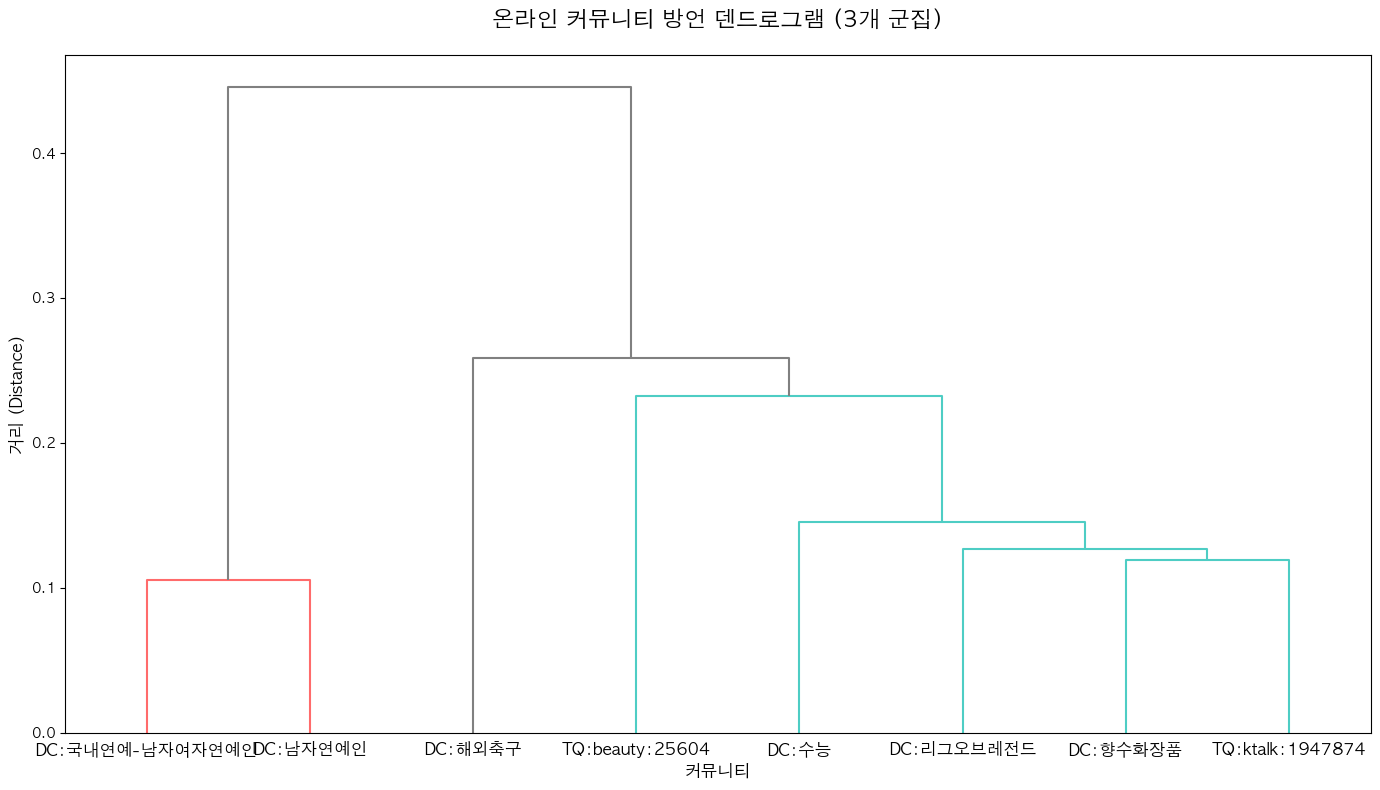

저장: ../data/results/dendrogram_k3.png


In [8]:
# 색상으로 군집 표시한 덴드로그램
from scipy.cluster.hierarchy import set_link_color_palette

set_link_color_palette(['#FF6B6B', '#4ECDC4', '#FFD93D'])

plt.figure(figsize=(14, 8))
dendrogram(linkage_matrix, labels=community_labels, 
           leaf_font_size=12, 
           color_threshold=linkage_matrix[-k+1, 2],
           above_threshold_color='gray')
plt.title(f'온라인 커뮤니티 방언 덴드로그램 ({k}개 군집)', fontsize=16, pad=20)
plt.xlabel('커뮤니티', fontsize=12)
plt.ylabel('거리 (Distance)', fontsize=12)
plt.tight_layout()
plt.savefig(results_dir / f'dendrogram_k{k}.png', dpi=150, bbox_inches='tight')
plt.show()

print(f"저장: {results_dir / f'dendrogram_k{k}.png'}")

## 5. 군집별 특징 분석

In [9]:
# 군집별로 구성원 출력
clusters_dict = {}
for i in range(1, k+1):
    members = [community_labels[j] for j in range(len(community_labels)) if cluster_labels[j] == i]
    clusters_dict[f'Cluster {i}'] = members
    print(f"군집 {i}:")
    for member in members:
        print(f"  - {member}")

군집 1:
  - DC:국내연예-남자여자연예인
  - DC:남자연예인
군집 2:
  - DC:향수화장품
  - DC:수능
  - TQ:beauty:25604
  - DC:리그오브레전드
  - TQ:ktalk:1947874
군집 3:
  - DC:해외축구


In [10]:
# 결과 저장
with open(results_dir / 'clustering_result.txt', 'w', encoding='utf-8') as f:
    f.write("=" * 60 + "")
    f.write("계층적 군집 분석 결과")
    f.write("=" * 60 + "")
    f.write(f"군집 수: {k}개")
    f.write("방법: Ward linkage")
    
    for cluster_name, members in clusters_dict.items():
        f.write(f"{cluster_name}:")
        for member in members:
            f.write(f"  - {member}")

print(f"저장: {results_dir / 'clustering_result.txt'}")

저장: ../data/results/clustering_result.txt


## 결론

계층적 군집 분석을 통해:
1. 커뮤니티 간 언어적 친족 관계 파악
2. 유사한 언어 패턴을 가진 커뮤니티 그룹화
3. 덴드로그램으로 방언 분화 과정 시각화

이는 온라인 커뮤니티의 **방언 구획**에 대한 명확한 증거를 제공합니다.